In [12]:
import numpy as np
import pandas as pd
import math

from scipy.optimize import minimize, Bounds, fmin_cg
from skopt import gp_minimize
from deap import base, creator, tools, algorithms
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import seaborn as sns

import yfinance as yf
import pandas_datareader as pdr
import pandas_market_calendars as mcal

import datetime

In [114]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=1800) #5 years analysis
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

#S&P 500 ticker
SnP_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol

def final_ticker(T_list):
    return list(set(T_list))

index_banch_mart = ["SPY"]

tickers = final_ticker(SnP_componet_ticker)

def get_stock_data(tickers_list, start_date, end_date=None):
    
    all_tickers = list(dict.fromkeys(tickers_list))
    
    data = yf.download(all_tickers, start=start_date, end=end_date)['Close']
    if isinstance(data, pd.DataFrame):
        data = data.dropna(axis=1)
        available_tickers = list(data.columns)
    else:
        available_tickers = all_tickers
    
    return data, available_tickers

def initialize_portfolio(tickers, equal_weight=True):
    n_assets = len(tickers)
    if equal_weight:
        weight = 1.0/n_assets
    else:
        weight = 1.0
        
    return {ticker: weight for ticker in tickers}

df,tickers = get_stock_data(tickers,valid_start_day)

df_BM,_ = get_stock_data(index_banch_mart, valid_start_day)
number_of_stocks = df.shape[1]

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['META']: ConnectionError(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')))
['ETR', 'BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-03-18 -> 2025-02-20)')
[*********************100%***********************]  1 of 1 completed


In [153]:
def Get_rfr(start):
    risk_free_rate = pd.DataFrame()
    shifted_date = 0 # change this if you run this on a non-trading day, just in case
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', start).dropna()
        shifted_date += 1
    return risk_free_rate/100
rfr = Get_rfr(valid_start_day)

In [115]:
ret_df = np.log(df/df.shift(1)).dropna()
ret_df_BM = np.log(df_BM/df_BM.shift(1)).dropna()

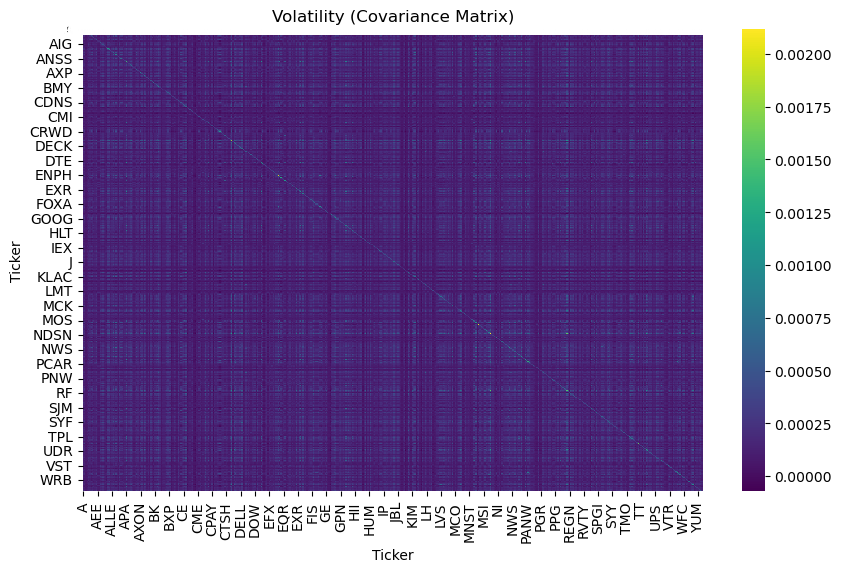

In [116]:
Covarian_matrix = ret_df.cov()
plt.figure(figsize=(10, 6))
sns.heatmap(Covarian_matrix, annot=True, cmap='viridis', fmt='.2e')
plt.title('Volatility (Covariance Matrix)')
plt.show()

In [88]:
def perform_pca_analysis(returns_df, variance_threshold=0.90):
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_returns = scaler.fit_transform(returns_df)
    
    # Initialize PCA with all components
    pca = PCA()
    pca.fit(scaled_returns)
    
    # Find number of components needed for threshold
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumsum >= variance_threshold) + 1
    
    # Perform PCA with determined number of components
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_returns)
    
    # Create DataFrame for principal components
    pc_df = pd.DataFrame(
        principal_components,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=returns_df.index
    )
    
    # Get component loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=returns_df.columns
    )
    
    # Calculate explained variance ratios
    explained_variance_ratio = pd.Series(
        pca.explained_variance_ratio_,
        index=[f'PC{i+1}' for i in range(n_components)]
    )
    
    cumulative_variance_ratio = explained_variance_ratio.cumsum()
    
    return {
        'principal_components': pc_df,
        'loadings': loadings,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'n_components': n_components
    }

# Use the function
pca_results = perform_pca_analysis(ret_df, variance_threshold=0.90)

# Display results
print(f"\nNumber of components needed to explain {90}% of variance: {pca_results['n_components']}")

print("\nExplained Variance Ratio:")
print(pca_results['explained_variance_ratio'])

print("\nCumulative Variance Ratio:")
print(pca_results['cumulative_variance_ratio'])

# Display top loadings for each component
for pc in pca_results['loadings'].columns:
    print(f"\n{pc} top 10 loadings:")
    print(pca_results['loadings'][pc].sort_values(ascending=False).head(10))
    print(f"\n{pc} bottom 10 loadings:")
    print(pca_results['loadings'][pc].sort_values(ascending=True).head(10))


Number of components needed to explain 90% of variance: 114

Explained Variance Ratio:
PC1      0.199843
PC2      0.081352
PC3      0.039035
PC4      0.031266
PC5      0.024250
           ...   
PC110    0.001911
PC111    0.001881
PC112    0.001826
PC113    0.001803
PC114    0.001796
Length: 114, dtype: float64

Cumulative Variance Ratio:
PC1      0.199843
PC2      0.281195
PC3      0.320230
PC4      0.351496
PC5      0.375746
           ...   
PC110    0.894204
PC111    0.896084
PC112    0.897910
PC113    0.899714
PC114    0.901510
Length: 114, dtype: float64

PC1 top 10 loadings:
Ticker
CBOE    0.011958
K       0.005974
DXCM   -0.003796
CME    -0.006863
DG     -0.008046
WST    -0.009840
MCK    -0.010120
MRK    -0.010268
CEG    -0.011581
EW     -0.013034
Name: PC1, dtype: float64

PC1 bottom 10 loadings:
Ticker
ITW    -0.075968
PNC    -0.073358
RF     -0.072833
FITB   -0.072377
USB    -0.071844
TFC    -0.070958
PH     -0.070905
DOV    -0.070386
GS     -0.069940
HBAN   -0.069550
Name:

/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_31197/3121985549.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  pc_performance.loc[pc, 'Sharpe'] = (annual_return - window_annual_rfr) / annual_vol



Strategy Performance:
Annual Return: 1.1053
Annual Volatility: 0.7815
Sharpe Ratio: 1.3799

Benchmark Performance:
Annual Return: 0.2482
Annual Volatility: 0.1830
Sharpe Ratio: 1.2093


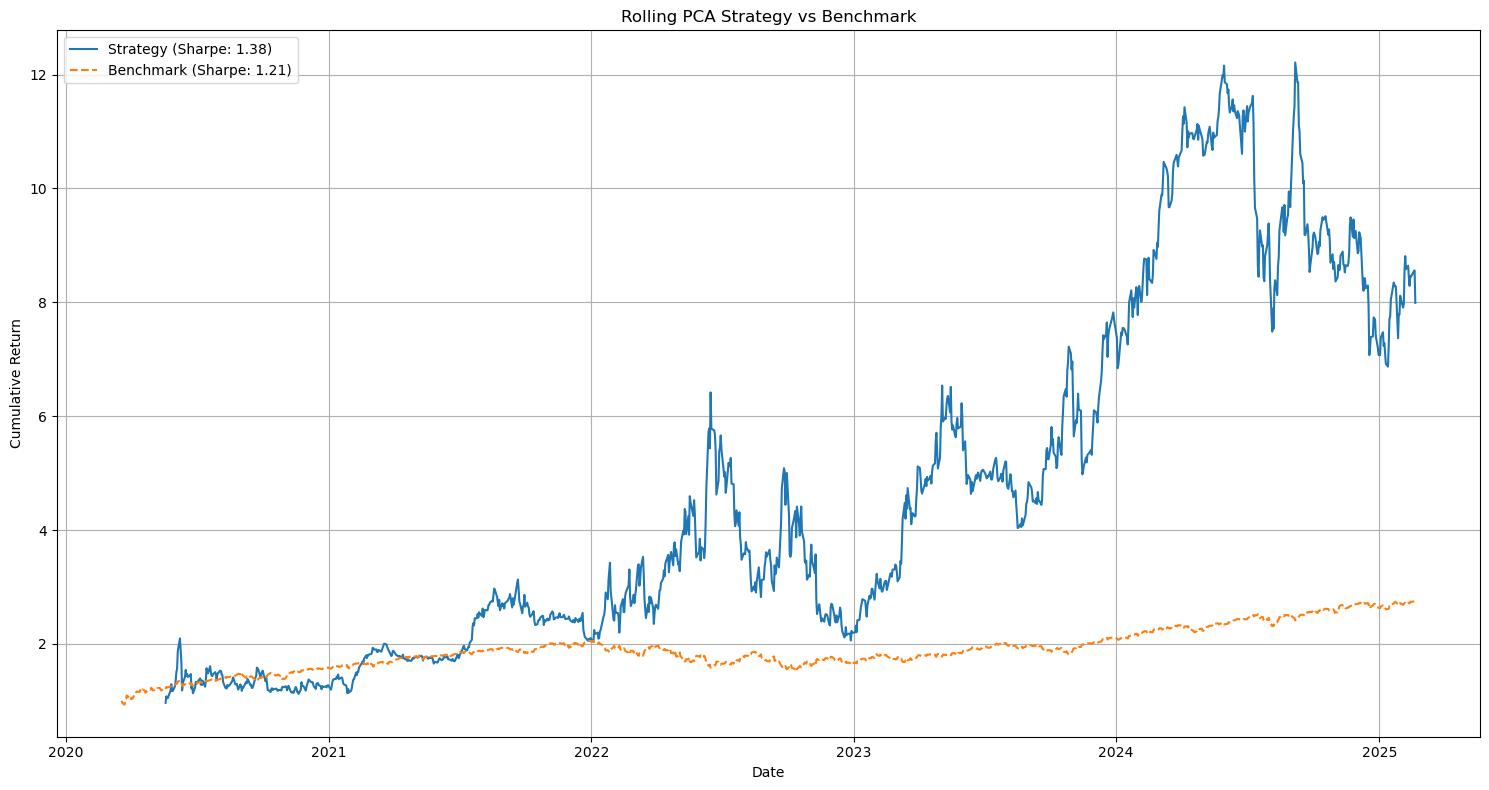

In [167]:
def rolling_pca_strategy(df, df_BM, rfr, lookback_days=63, holding_days=21, n_components=5):
    
    # Convert prices to log returns
    ret_df = np.log(df/df.shift(1)).dropna()
    ret_BM = np.log(df_BM/df_BM.shift(1)).dropna()
    
    # Reindex rfr to match trading days and forward fill
    rfr_aligned = rfr.reindex(ret_df.index, method='ffill')
    
    # Initialize results storage
    strategy_returns = pd.Series(index=ret_df.index, dtype=float)
    selected_pcs_history = []
    performance_history = []
    
    # Get all dates
    all_dates = ret_df.index.tolist()
    
    # Initialize the first start date
    current_idx = 0
    
    while current_idx < len(all_dates):
        start_date = all_dates[current_idx]
        
        # Define the PCA calculation window
        lookback_start_idx = max(0, current_idx - lookback_days)
        window_data = ret_df.iloc[lookback_start_idx:current_idx]
        
        if len(window_data) < 30:  # Skip if not enough data
            current_idx += holding_days
            continue
        
        # Get risk-free rate for the window
        window_rfr = rfr_aligned.loc[window_data.index].mean().values[0] / 252  # Convert annual to daily
        
        # Perform PCA
        pca = PCA(n_components=min(len(window_data.columns), len(window_data)))
        pca_results = pca.fit_transform(window_data.values)
        
        # Create DataFrame with PCA results
        pca_results = pd.DataFrame(pca_results,
                                 index=window_data.index,
                                 columns=[f'PC{i+1}' for i in range(pca_results.shape[1])])
        
        # Get loadings
        loadings = pd.DataFrame(pca.components_.T,
                              index=window_data.columns,
                              columns=pca_results.columns)
        
        # Calculate PC returns and Sharpe ratios
        pc_performance = pd.DataFrame(index=pca_results.columns)
        
        for pc in pca_results.columns:
            pc_returns = (window_data @ loadings[pc])
            simple_returns = np.exp(pc_returns) - 1
            annual_return = (1 + simple_returns.mean()) ** 252 - 1
            annual_vol = simple_returns.std() * np.sqrt(252)
            window_annual_rfr = window_rfr * 252  # Convert daily back to annual for Sharpe
            pc_performance.loc[pc, 'Sharpe'] = (annual_return - window_annual_rfr) / annual_vol
        
        # Select top N PCs
        top_pcs = pc_performance.nlargest(n_components, 'Sharpe').index
        selected_pcs_history.append((start_date, top_pcs))
        
        # Define holding period
        hold_end_idx = min(current_idx + holding_days, len(all_dates))
        hold_dates = all_dates[current_idx:hold_end_idx]
        
        if len(hold_dates) == 0:
            break
            
        # Calculate strategy returns during holding period
        holding_window = ret_df.loc[hold_dates]
        
        # Create portfolio weights by combining PC weights
        portfolio_weights = pd.Series(0.0, index=window_data.columns)
        for pc in top_pcs:
            portfolio_weights += loadings[pc] / len(top_pcs)
            
        # Calculate portfolio returns using the combined weights
        portfolio_returns = (holding_window * portfolio_weights).sum(axis=1)
        strategy_returns.loc[hold_dates] = portfolio_returns
        
        # Move to next period
        current_idx += holding_days
    
    # Convert log returns to simple returns for final performance calculation
    strategy_simple_returns = np.exp(strategy_returns) - 1
    strategy_cum_returns = (1 + strategy_simple_returns).cumprod()
    
    # Calculate benchmark returns for comparison
    benchmark_simple_returns = np.exp(ret_BM) - 1
    benchmark_cum_returns = (1 + benchmark_simple_returns).cumprod()
    
    # Get average risk-free rate for the entire period
    final_rfr = rfr_aligned.mean().values[0]  # Annual rate
    
    # Calculate performance metrics
    strategy_annual_return = (1 + strategy_simple_returns.mean()) ** 252 - 1
    strategy_annual_vol = strategy_simple_returns.std() * np.sqrt(252)
    strategy_sharpe = (strategy_annual_return - final_rfr) / strategy_annual_vol
    
    benchmark_annual_return = ((1 + benchmark_simple_returns.mean()) ** 252 - 1).values[0]
    benchmark_annual_vol = (benchmark_simple_returns.std() * np.sqrt(252)).values[0]
    benchmark_sharpe = (benchmark_annual_return - final_rfr) / benchmark_annual_vol
    
    # Plot results
    fig, ax = plt.subplots(figsize=(15, 8))
    
    ax.plot(strategy_cum_returns.index, strategy_cum_returns, 
            label=f'Strategy (Sharpe: {strategy_sharpe:.2f})')
    ax.plot(benchmark_cum_returns.index, benchmark_cum_returns, 
            label=f'Benchmark (Sharpe: {benchmark_sharpe:.2f})',
            linestyle='--')
    
    ax.set_title('Rolling PCA Strategy vs Benchmark')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    
    # Print performance summary
    print("\nStrategy Performance:")
    print(f"Annual Return: {strategy_annual_return:.4f}")
    print(f"Annual Volatility: {strategy_annual_vol:.4f}")
    print(f"Sharpe Ratio: {strategy_sharpe:.4f}")
    
    print("\nBenchmark Performance:")
    print(f"Annual Return: {benchmark_annual_return:.4f}")
    print(f"Annual Volatility: {benchmark_annual_vol:.4f}")
    print(f"Sharpe Ratio: {benchmark_sharpe:.4f}")
    
    return {
        'strategy_returns': strategy_returns,
        'strategy_cum_returns': strategy_cum_returns,
        'selected_pcs_history': selected_pcs_history,
        'performance_metrics': {
            'strategy': {
                'return': strategy_annual_return,
                'volatility': strategy_annual_vol,
                'sharpe': strategy_sharpe
            },
            'benchmark': {
                'return': benchmark_annual_return,
                'volatility': benchmark_annual_vol,
                'sharpe': benchmark_sharpe
            }
        }
    }

# Run the backtest
rfr = Get_rfr(valid_start_day)
results = rolling_pca_strategy(df, df_BM, rfr)
plt.show()